In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
df_L = pd.read_csv('clean_df.csv')

df_L['Time'] = np.arange(len(df_L.index))

df_L = df_L[['date','Price','Time']]

In [3]:
df_L.set_index('date', inplace=True)

C:\Users\dicod\AppData\Local\Temp\ipykernel_7700\1345334142.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


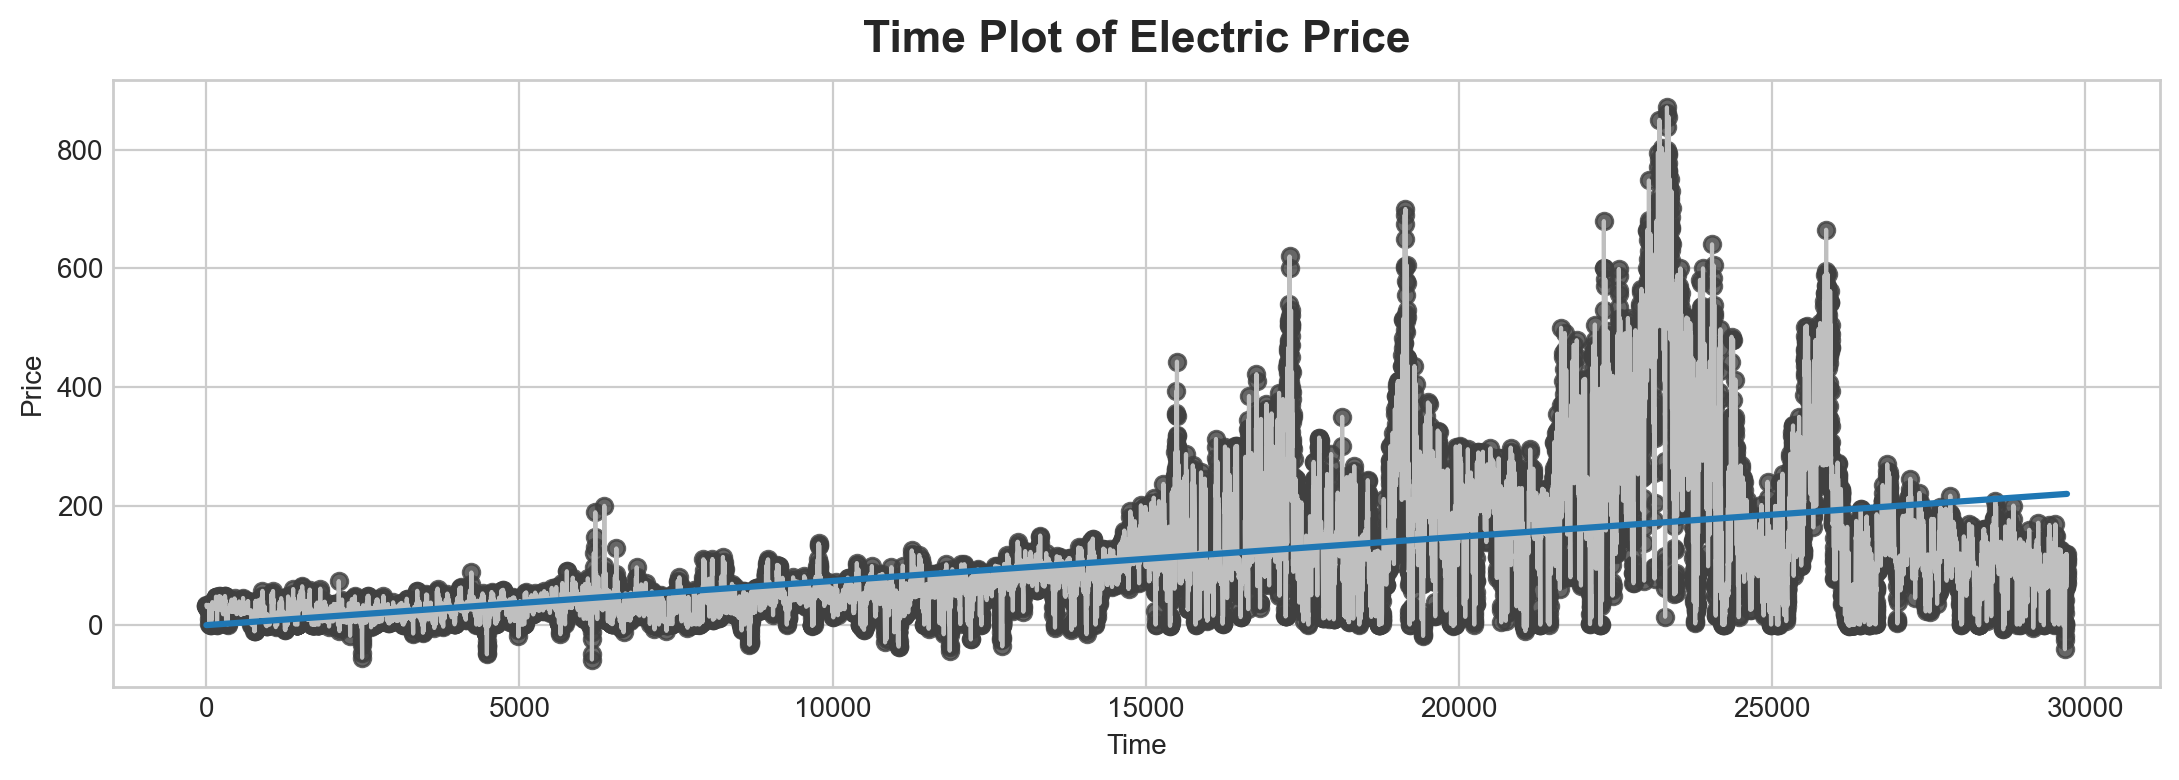

In [4]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('Time', 'Price', data=df_L, color='0.75')
ax = sns.regplot(x='Time', y='Price', data=df_L, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Electric Price');

In [5]:
# Lag features¶
# To make a lag feature we shift the observations of the target series so that they appear to have occured later in time.
# Here we've created a 1-step lag feature, though shifting by multiple steps is possible too.
df_L['Lag_1'] = df_L['Price'].shift(1)
df_L_lag = df_L.reindex(columns=['Price', 'Lag_1'])

df_L_lag.head()

,Price,Lag_1
date,,
01.01.2020 00:00,33.42,NaN
01.01.2020 01:00,31.77,33.42
01.01.2020 02:00,31.57,31.77
01.01.2020 03:00,31.28,31.57
01.01.2020 04:00,30.85,31.28


#### Why we use lag in timeseries data?

Time series analysis uses lags because the value of a time series at a given point in time can be dependent on the values of the series at previous points in time. In other words, the behavior of a time series at time t can be influenced by its values at times t-1, t-2, and so on.

A lag is simply a time shift of a time series by a certain number of time periods. For example, the first-order lag of a time series at time t is its value at time t-1. By analyzing the relationship between a time series and its lagged values, we can identify patterns, trends, and other characteristics of the series.

Lagging a time series can be useful for a variety of purposes in time series analysis, such as:

Prediction: By using lagged values of a time series as input features, we can build models to forecast future values of the series.

Autocorrelation analysis: Lagging a time series allows us to calculate its autocorrelation function (ACF), which measures the correlation between the series and its lagged values. The ACF can be used to identify the presence of trends, seasonal patterns, and other forms of correlation in the series.

Stationarity testing: A stationary time series is one whose statistical properties (such as mean and variance) do not change over time. By lagging a time series and calculating its ACF, we can test whether the series is stationary or not.

Overall, lags play an important role in time series analysis by allowing us to analyze the temporal dependencies between a series and its past values, and to extract useful information for forecasting and analysis.

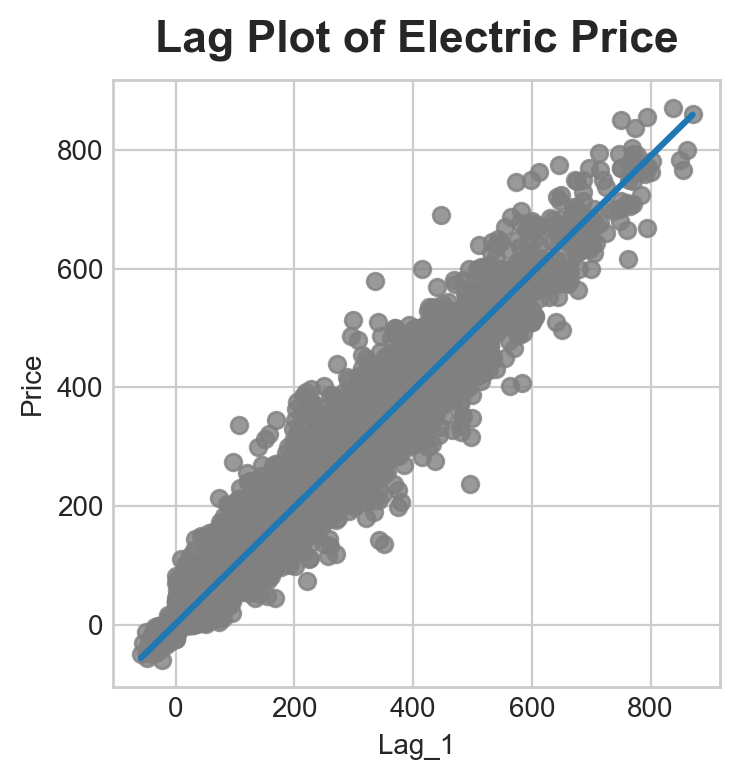

In [6]:
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='Price', data=df_L, ci=None, scatter_kws=dict(color='0.5'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Electric Price');

Text(0.5, 1.0, 'Time Plot of Electric Price_Linear Prediction')

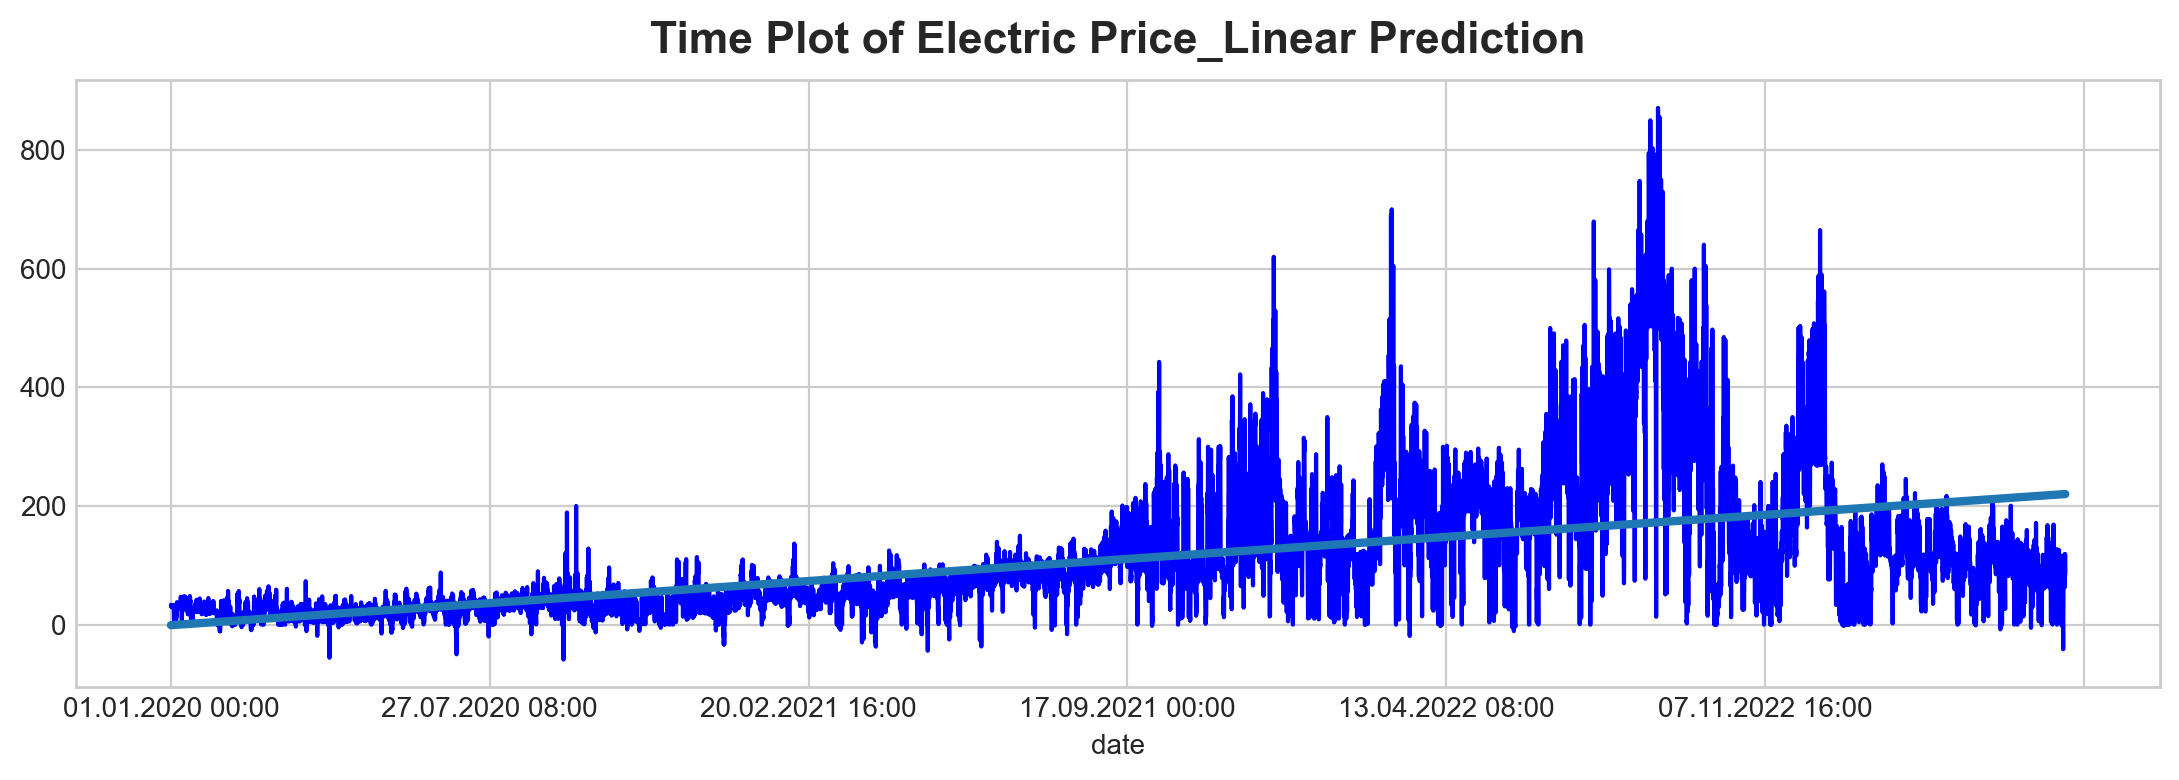

In [7]:


# Training data
X = df_L.loc[:, ['Time']]  # features
y = df_L.loc[:, 'Price']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

plot_params = {'color': 'blue', 'linestyle': '-'}

ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Electric Price_Linear Prediction')

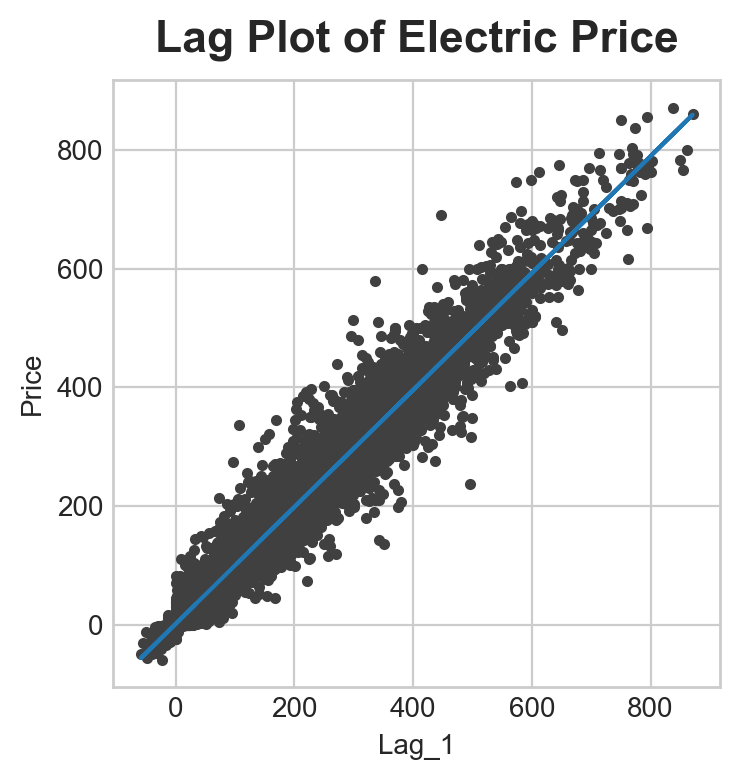

In [8]:
X = df_L.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df_L.loc[:, 'Price']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('Price')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Electric Price');

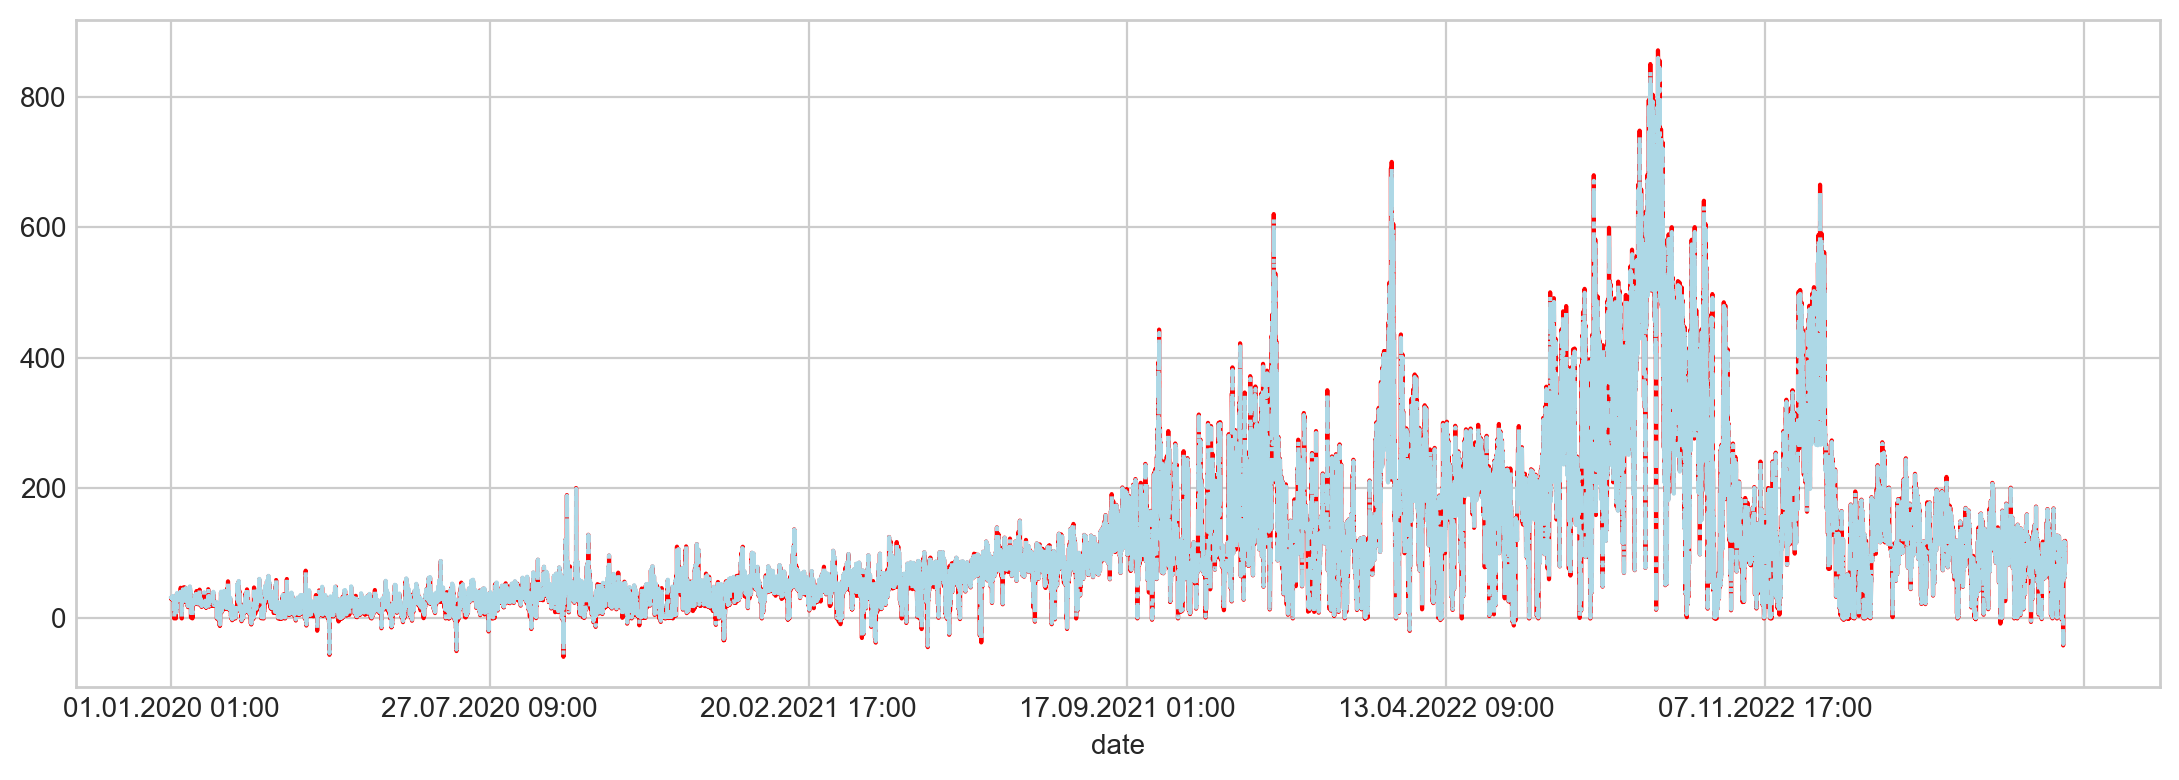

In [9]:
plot_params_actu = {'color': 'red', 'linestyle': '-'}
plot_params_pred = {'color': 'lightblue', 'linestyle': 'dashdot'}

ax = y.plot(**plot_params_actu)
ax = y_pred.plot(**plot_params_pred)

In [10]:
squared_diff = (y_pred - y) ** 2
    
# Calculate the mean squared error
mse = np.mean(squared_diff)
rmse = np.sqrt(mse)

print('Root Mean Squared Error:', rmse)

Root Mean Squared Error: 20.208679473068624


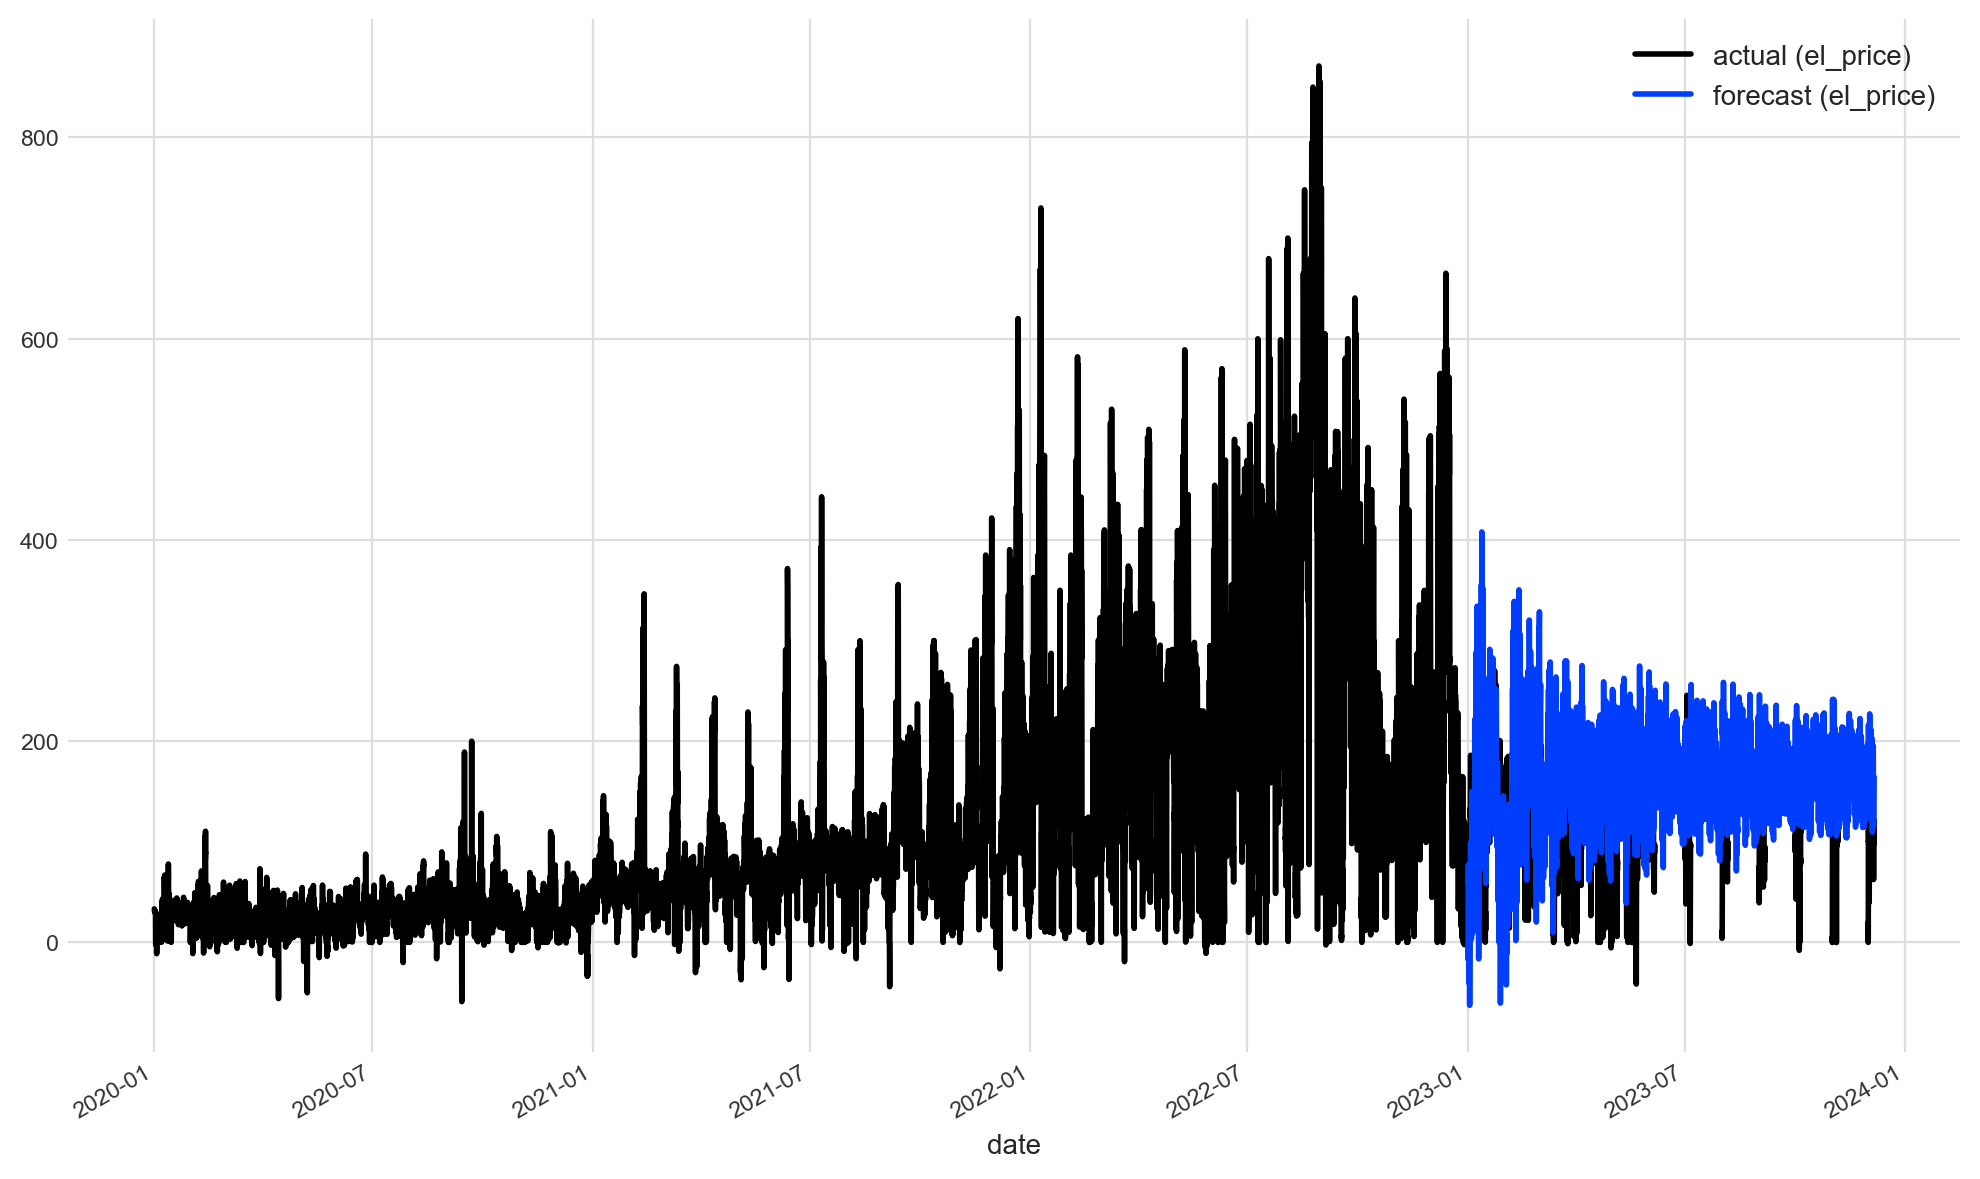

In [11]:
from darts.models import RegressionModel
from sklearn.linear_model import BayesianRidge
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

df = pd.read_csv('df_clean.csv')
ts = TimeSeries.from_dataframe(df, time_col='date', value_cols = 'Price', fill_missing_dates=True, freq=None)
train, test = ts.split_after(pd.Timestamp("01.01.2023 01:00"))

scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)
series_scaled = scaler.transform(ts)

model = RegressionModel(lags=2400, model=BayesianRidge()) # we look at past 100 days of the target!

model.fit(train_scaled)

pred = model.predict(
    series = train_scaled,
    n=len(test_scaled),
)

# scale back:
pred = scaler.inverse_transform(pred)

plt.figure(figsize=(10, 6))
ts.plot(label="actual (el_price)")
pred.plot(label="forecast (el_price)")

In [12]:
# we have an issue, mape evluation function, it does not support negative and 0 values... 

from darts.metrics import mape
from darts.metrics import rmse
# mape (ts, pred)
rmse(ts, pred)

81.44736296295595

## A less naive model

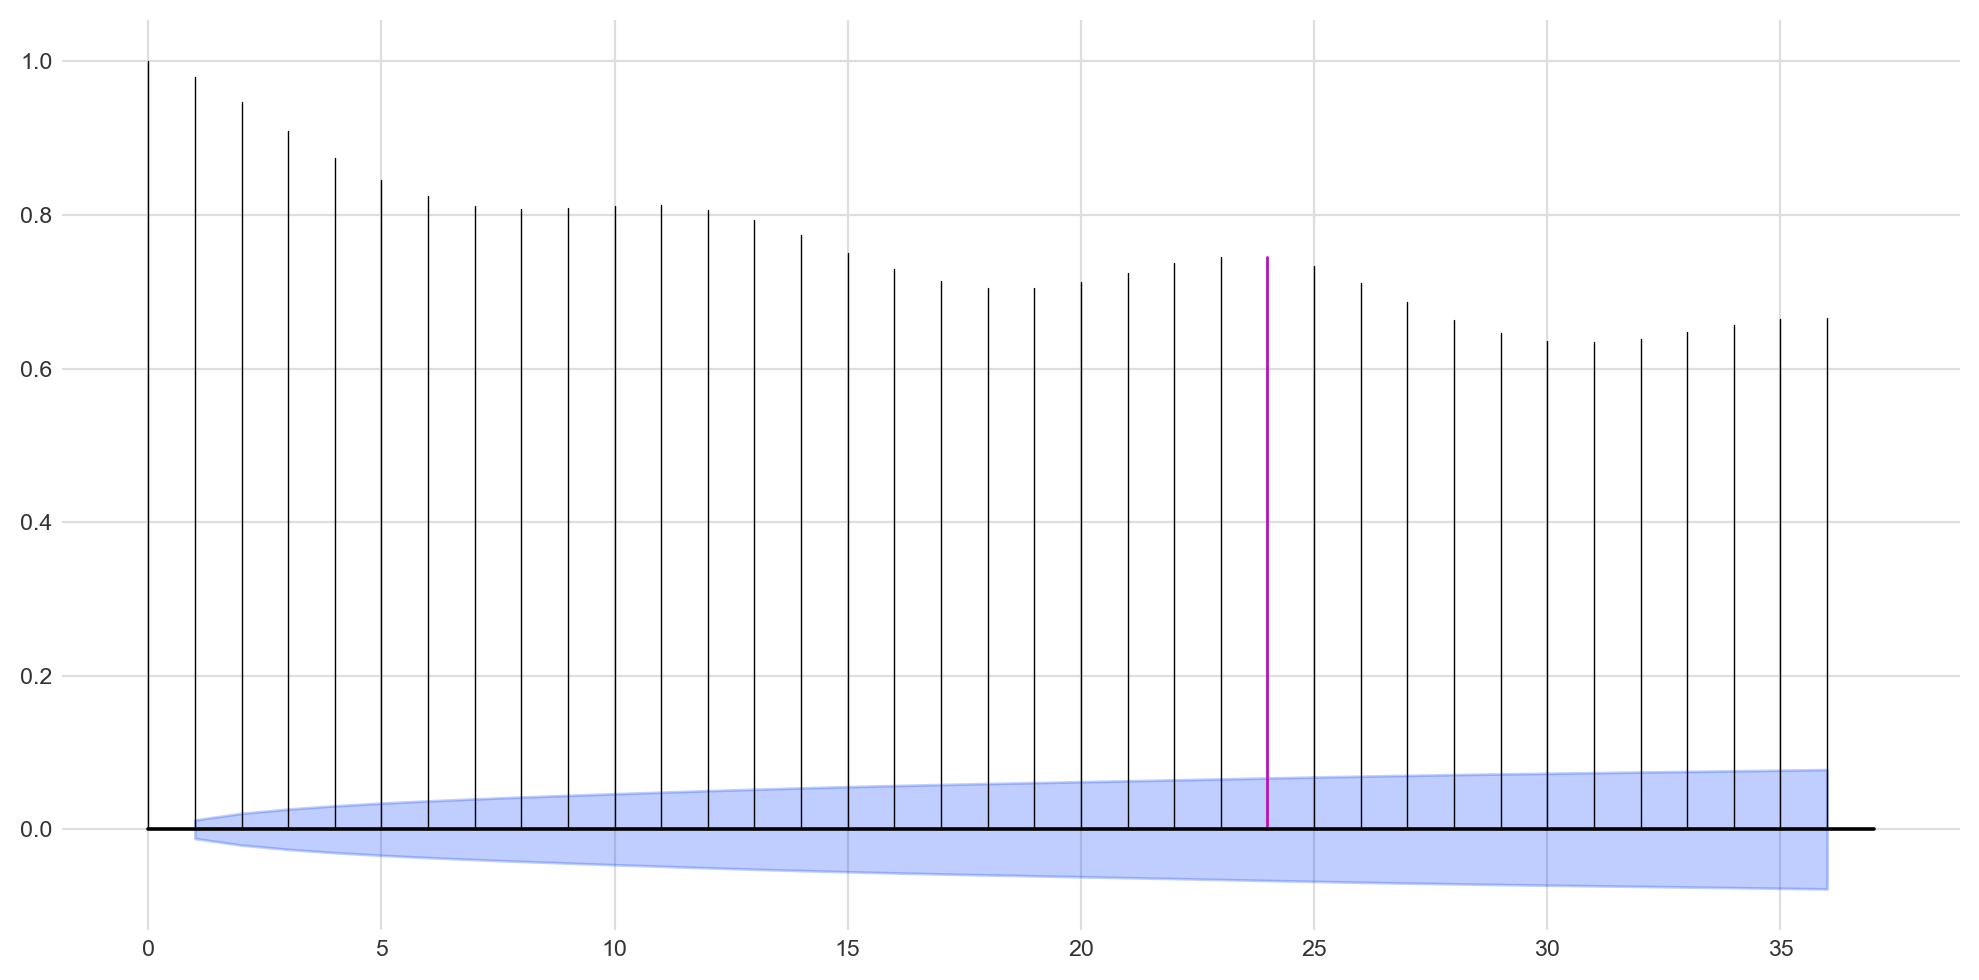

In [13]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=24, max_lag = 36, alpha=0.05)

for m in range(2, 36):
    is_seasonal, period = check_seasonality(train, m=24, max_lag = 36, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

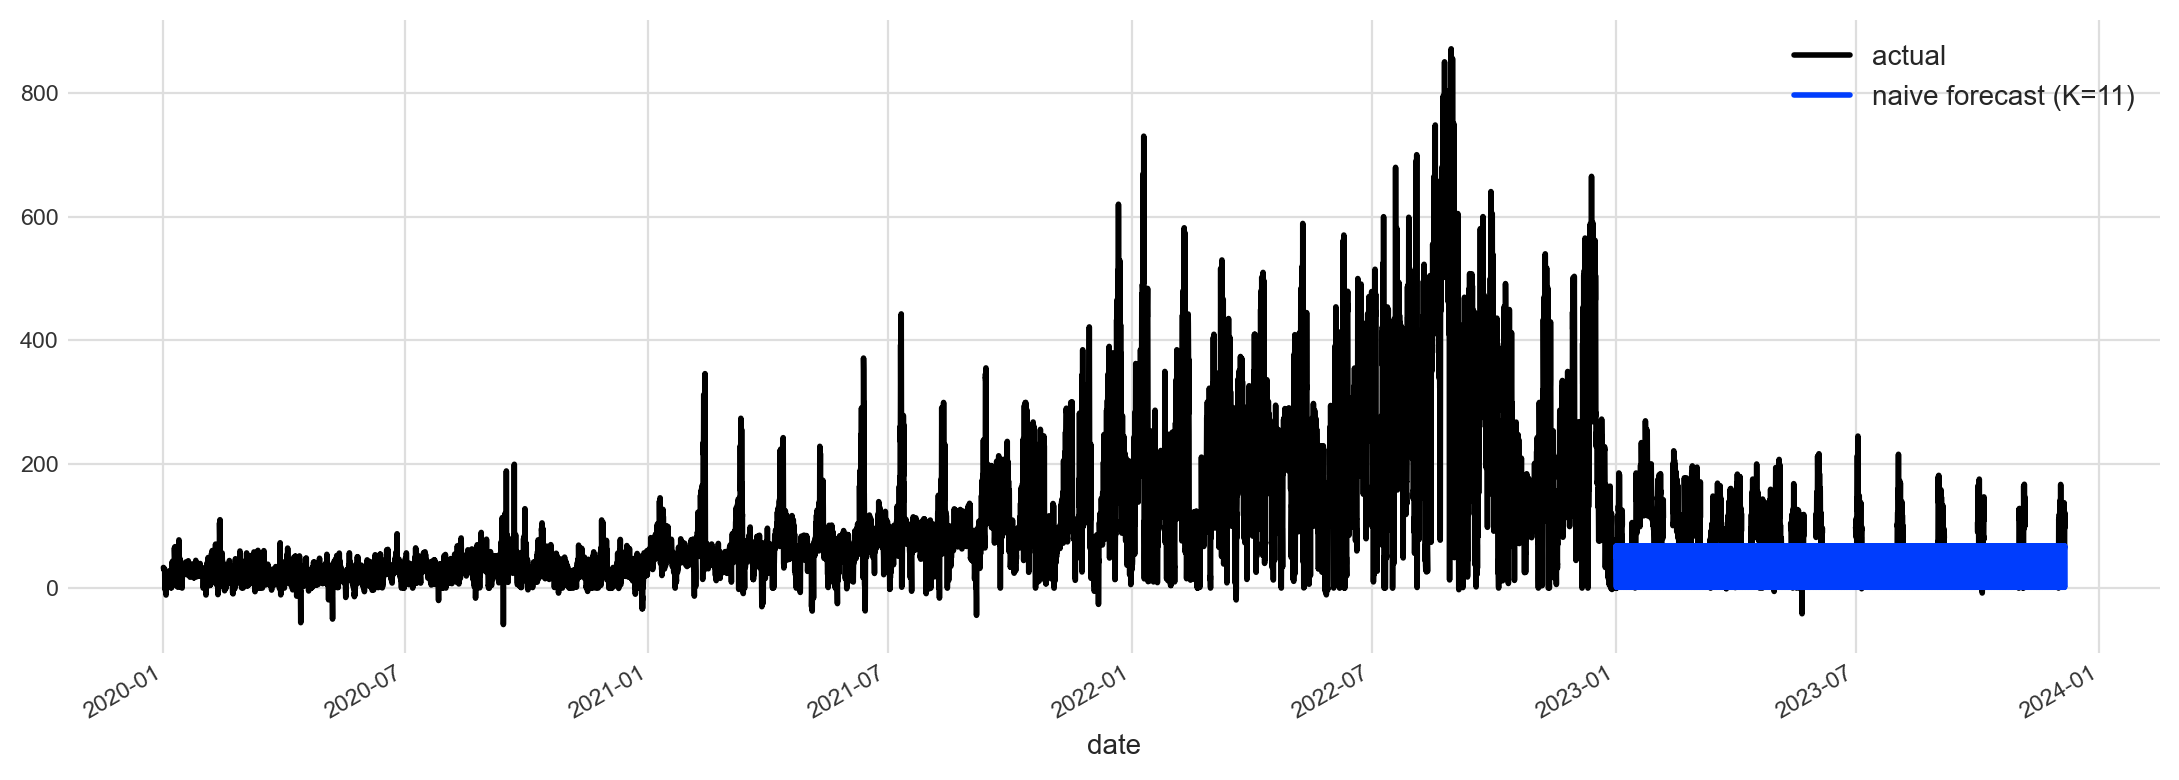

In [14]:
from darts.models import NaiveSeasonal

seasonal_model = NaiveSeasonal(K=11)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(len(test_scaled))

ts.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=11)")

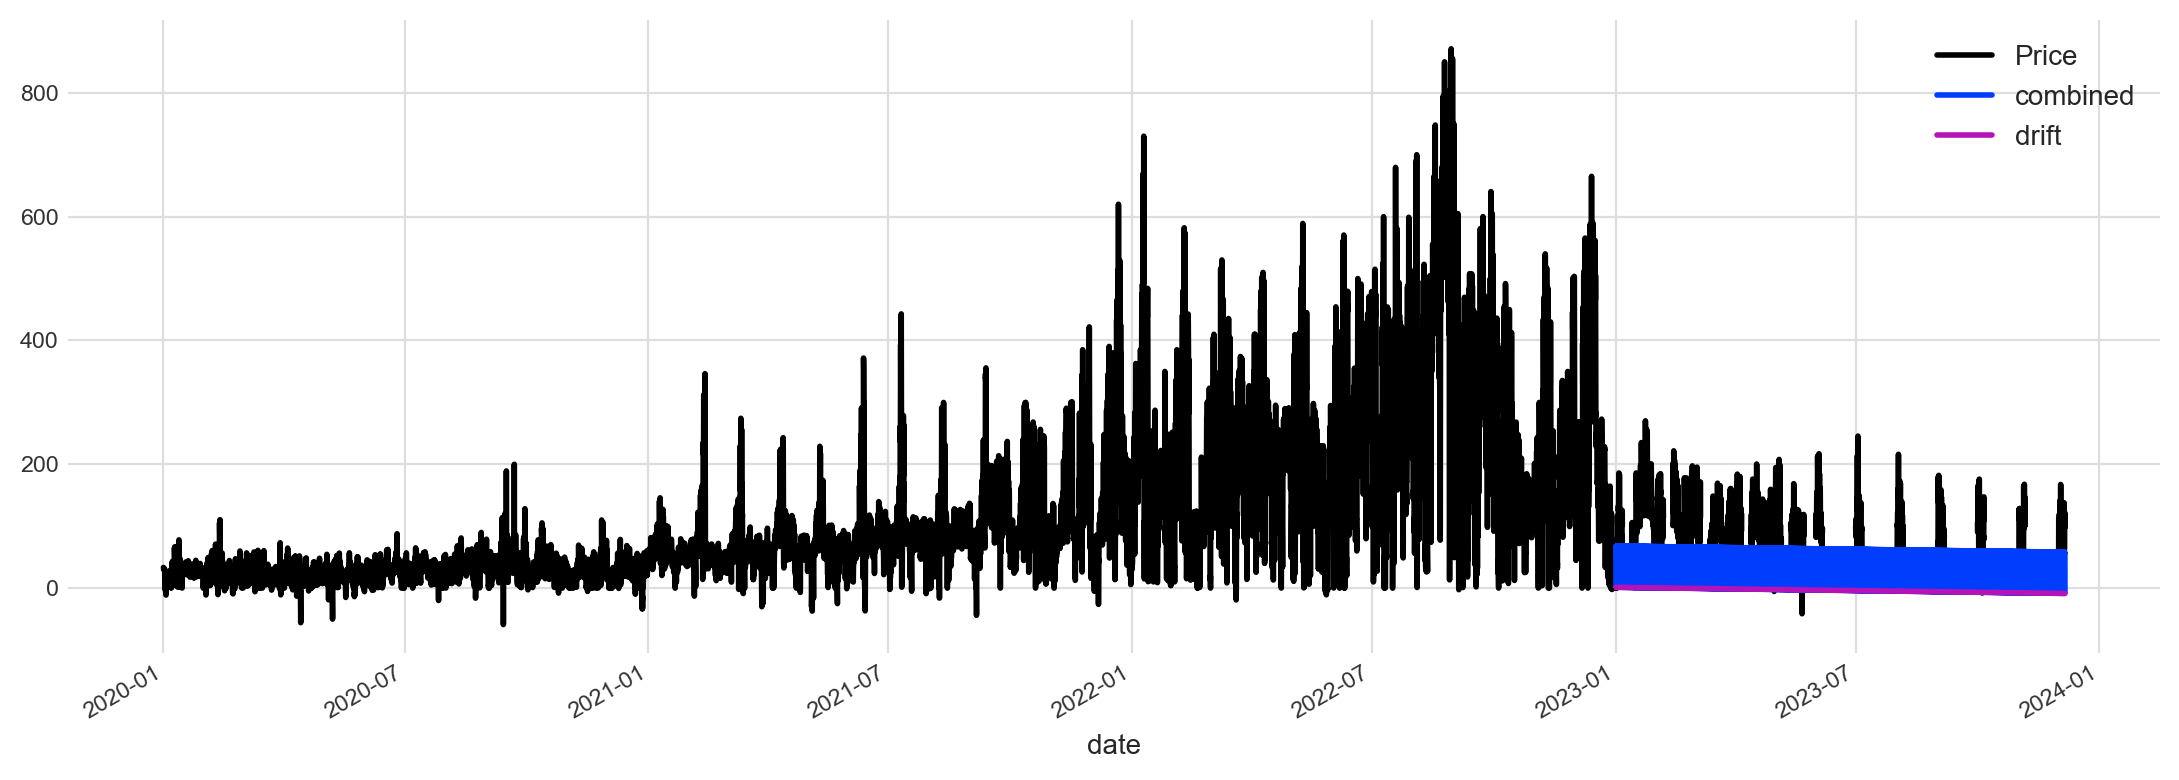

In [15]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(len(test_scaled))

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

ts.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

In [16]:
# oh my god!

from darts.metrics import rmse

print(
    "Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
        rmse(ts, combined_forecast)
    )
)

Mean absolute percentage error for the combined naive drift + seasonal: 87.09%.


In [ ]:
# it takes long time, I stop working

from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta


def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(ts))
    print("model {} obtains RMSE: {:.2f}%".format(model, rmse(ts, forecast)))


eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())
# eval_model(Theta())
# ValueError: Multiplicative seasonality is not appropriate for zero and negative values

model ExponentialSmoothing() obtains RMSE: 73.02%


In [ ]:
model_es = ExponentialSmoothing()
model_es.fit(train)
probabilistic_forecast = model_es.predict(len(ts), num_samples=500)

series.plot(label="actual")
probabilistic_forecast.plot(label="probabilistic forecast")
plt.legend()
plt.show()